# Assignment RL Flappy Bird, Alexandre SELVESTREL

Make the imports

In [1]:
import os, sys
import gymnasium as gym
import time
from tqdm import tqdm
import text_flappy_bird_gym
import pickle
import wandb
import datetime
import numpy as np
import matplotlib.pyplot as plt
import flappy_bird_gym



## Easy version of flappy bird (the one specific to the assignment):

Define how to process the date for the full screen

In [2]:
def process(obs,n,k,g):# obs is 20x15 initially
    line_pnj = round(n/3) - 1
    new_pos = 0
    found = False
    for j in range(k):
        if obs[line_pnj,j] == 1:
            new_pos = j
            found = True
    if found is False:
        raise ValueError("bird not found")
    obstacles_bas = []
    i = line_pnj +1
    while (len(obstacles_bas) <2) and i<n:
            found = False
            for j in range(g + 1):
                 if (obs[i,j] == 2) and (found is False):
                    obstacles_bas.append(i)
                    found = True
            i += 1
    if len(obstacles_bas) == 0:
        raise ValueError("no obstacle found")
    dist_vert = [bas - line_pnj for bas in obstacles_bas]
    gauche = []
    droite = []
    for i in obstacles_bas:
        line = obs[i,:]
        found  = False
        for j,elem in enumerate(line):
            if (elem == 0) and (found is False):
                gauche.append(j)
                found = True
            elif (elem == 2) and (found is True):
                droite.append(j - 1)
                found = False
            elif line[k - 1] == 0:
                droite.append(k - 1)
                found = False
    for a in range(len(obstacles_bas)):
        if droite[a] - gauche[a] != g-1:
            print(obs)
            print('taille erreur',gauche[a],droite[a])
            raise ValueError("gap mauvaise taille")
    center = [gauche[i] + round(g/2) for i in range(len(droite))]
    state = tuple([(new_pos,dist_vert[i],center[i] - new_pos) for i in range(len(dist_vert))])
    return state

Define the policies

In [3]:
class MC:
    def __init__(self,eps,alpha,n_max_step,height,width,gap,trained = False, processed = True) -> None:
        self.eps = eps
        self.alpha = alpha
        self.n_max_step = n_max_step
        self.nsteps = 0
        self.processed = processed
        self.height = height
        self.width = width
        self.gap = gap
        if trained is False:
            self.q = {}
        else:
            if self.processed is True:
                with open('data/MC.pkl', 'rb') as f:
                    self.q = pickle.load(f)
            else:
                with open('data/MC_non_processed.pkl', 'rb') as f:
                    self.q = pickle.load(f)

    def reset(self):
        self.episode = []
        self.nsteps = 0

    def chose_action(self,observation, training = True):
        if self.processed is True:
            state = observation
            #print(state)
        else:
            state = process(observation,n = self.width, k = self.height, g = self.gap)
            #print('state',state)
            #print(observation)
            #time.sleep(0.5)
        if (state,0) not in list(self.q.keys()):
            self.q[(state,0)] = np.random.uniform(-10,10)
        if (state,1) not in list(self.q.keys()):
            self.q[(state,1)] = np.random.uniform(-10,10)
        if training:
            if np.random.uniform(0,1) < self.eps:
                action = np.random.choice([0,1])
                self.episode.append({'state':state,'action':action})
                self.nsteps += 1
                return action
        action = 0 if self.q[(state,0)] > self.q[(state,1)] else 1
        self.episode.append({'state':state,'action':action})
        self.nsteps += 1
        return action
    
    def update(self,reward,next_observation,done):
        if self.nsteps == self.n_max_step:
            reward = 100
        if done:
            reward = -10
        self.episode[-1]['reward'] = reward
        if (done is False) and (self.nsteps < self.n_max_step):
            pass
        else:
            G = 0
            for j in range(len(self.episode)):
                i = len(self.episode) - j - 1
                G += self.episode[i]['reward']
                self.q[(self.episode[i]['state'],self.episode[i]['action'])] += self.alpha*(G - self.q[(self.episode[i]['state'],self.episode[i]['action'])])
    
    def save(self):
        if self.processed is True:
            with open('data/MC.pkl', 'wb') as f:
                pickle.dump(self.q, f)
        else:
            with open('data/MC_non_processed.pkl', 'wb') as f:
                pickle.dump(self.q, f)




In [4]:
class Sarsa:
    def __init__(self,eps,alpha,n_max_step,height,width,gap,trained = False, processed = True, lambd = 0.9) -> None:
        self.eps = eps
        self.alpha = alpha
        self.n_max_step = n_max_step
        self.nsteps = 0
        self.processed = processed
        self.height = height
        self.width = width
        self.gap = gap
        self.lambd = lambd
        if trained is False:
            self.q = {}
            self.e = {}
        else:
            if self.processed is True:
                with open('data/Sarsa_q.pkl', 'rb') as f:
                    self.q = pickle.load(f)
                with open('data/Sarsa_e.pkl', 'rb') as f:
                    self.e = pickle.load(f)
            else:
                with open('data/Sarsa_non_processed_q.pkl', 'rb') as f:
                    self.q = pickle.load(f)
                with open('data/Sarsa_non_processed_e.pkl', 'rb') as f:
                    self.e = pickle.load(f)

    def reset(self):
        self.nsteps = 0

    def chose_action(self,observation, training = True):
        if self.processed is True:
            state = observation
        else:
            state = process(observation,n = self.width, k = self.height, g = self.gap)
        self.current_state = state
        if (state,0) not in list(self.q.keys()):
            self.q[(state,0)] = np.random.uniform(-10,10)
            self.e[(state,0)] = 0
        if (state,1) not in list(self.q.keys()):
            self.q[(state,1)] = np.random.uniform(-10,10)
            self.e[(state,1)] = 0
        if training:
            if np.random.uniform(0,1) < self.eps:
                action = np.random.choice([0,1])
                self.nsteps += 1
                return action
        action = 0 if self.q[(state,0)] > self.q[(state,1)] else 1
        self.nsteps += 1
        self.current_action = action   
        return action
    
    def update(self,reward,next_observation,done):
        if self.processed is True or done:
            pass
        else:
            next_observation = process(next_observation,n = self.width, k = self.height, g = self.gap)
        if (self.nsteps == self.n_max_step) or done:
            max_q = 0
        else:
            if (next_observation,0) not in list(self.q.keys()):
                self.q[(next_observation,0)] = np.random.uniform(-10,10)
                self.e[(next_observation,0)] = 0
            if (next_observation,1) not in list(self.q.keys()):
                self.q[(next_observation,1)] = np.random.uniform(-10,10)
                self.e[(next_observation,1)] = 0
            max_q = max(self.q[(next_observation,0)],self.q[(next_observation,1)])
        delta = reward + max_q - self.q[(self.current_state,self.current_action)]
        self.e[(self.current_state,self.current_action)] += 1
        for key in self.q.keys():
            self.q[key] += self.alpha*delta*self.e[key]
            self.e[key] *= self.lambd

    def save(self):
        if self.processed is True:
            with open('data/Sarsa_q.pkl', 'wb') as f:
                pickle.dump(self.q, f)
            with open('data/Sarsa_e.pkl', 'wb') as f:
                pickle.dump(self.e, f)
        else:
            with open('data/Sarsa_non_processed_q.pkl', 'wb') as f:
                pickle.dump(self.q, f)
            with open('data/Sarsa_non_processed_e.pkl', 'wb') as f:
                pickle.dump(self.e, f)


Run the code:

100%|██████████| 5000/5000 [00:46<00:00, 107.82it/s]


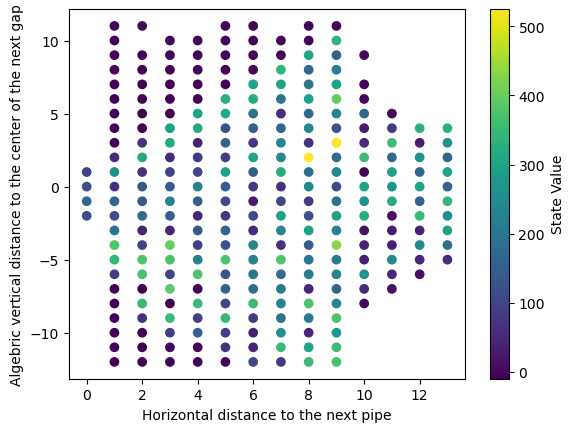

score moyen 571.03 nombre reussite totale 1
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=0)
(12, 0)
1
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=1)
(11,

KeyboardInterrupt: 

In [5]:
def training(env, policy,n_episodes, n_max_step,n_testing_moments = 100): # Train the agent
    li_scores = []
    for num_ep in tqdm(range(n_episodes)):
        done = False
        obs, info = env.reset()
        policy.reset()
        sep_test = n_episodes // n_testing_moments
        n_step = 0
        # iterate
        while (done is False) and (n_step < n_max_step):
            n_step += 1
            # Select next action
            action = policy.chose_action(obs,training = True)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            policy.update(reward,obs,done)
        #print(sep_test)
        if num_ep % sep_test == 0:
            score_moyen, n_terminated = testing(env,policy,n_episodes=1,n_max_step= n_max_step)
            li_scores.append(score_moyen)
            #print('score',score_moyen)
            if do_wandb:
                wandb.log({"score": score_moyen}, step=num_ep)
    return li_scores
                

def testing(env, policy,n_episodes, n_max_step): # Test the agent
    score_moyen = 0
    policy.reset()
    for _ in range(n_episodes):
        done = False
        obs,info = env.reset()
        n_step = 0
        # iterate
        n_terminated = 0 

        while (done is False) and (n_step < n_max_step):
            n_step += 1
            # Select next action
            action = policy.chose_action(obs,training = False)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            if n_step == n_max_step:
                n_terminated += 1
        score_moyen += n_step
    score_moyen = score_moyen/n_episodes
    return score_moyen, n_terminated

def show(env, policy,n_episodes):   # Show the agent playing the game
    policy.reset()
    for _ in range(n_episodes):
        done = False
        obs, info = env.reset()
        n_step = 0
        # iterate
        while (done is False):
            n_step += 1
            # Select next action
            action = policy.chose_action(obs,training = False)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
            print(obs)
            print(n_step)

def show_q(q): # Show the state value function
    x = []
    y = []
    value = []
    dic_indices = {}
    exist = []
    i = 0
    for key in q.keys():
        if (key[0][0],key[0][1]) not in exist and abs(key[0][1]) < 15 and key[0][0] < 25:
            x.append(key[0][0])
            y.append(key[0][1])
            value.append(q[key])
            dic_indices[(key[0][0],key[0][1])] = i
            exist.append((key[0][0],key[0][1]))
            i += 1
        elif abs(key[0][1]) < 15 and key[0][0] < 25:
            indice = dic_indices[(key[0][0],key[0][1])]
            value[indice] = max(value[indice],q[key])
    plt.scatter(x,y,c = value, cmap = 'viridis')
    plt.colorbar(label = 'State Value')
    plt.xlabel('Horizontal distance to the next pipe')  
    plt.ylabel('Algebric vertical distance to the center of the next gap')  
    plt.show()


if __name__ == '__main__':
    trained = False
    continue_training = False #if you want to continue training when the agent is already trained
    n_max_step = 1000
    n_training = 5000
    n_testing = 100
    n_testing_moments = 100
    eps = 0.01
    alpha = 0.2
    name_env = 'TextFlappyBird-v0' #minimal information
    #name_env = 'TextFlappyBird-screen-v0' #Full screen
    name_policy = 'MC'
    #name_policy = 'Sarsa'
    height = 15
    width = 20
    gap = 4
    do_wandb = False
    show_act_val = True
    
    if name_env == 'TextFlappyBird-v0':
        processed = True
    elif name_env == 'TextFlappyBird-screen-v0':
        processed = False
    else:
        raise ValueError("This environment doesn't exist!")
    for run in range(1):
        date = datetime.datetime.now().strftime('%dth%mmo_%Hh%Mmin%Ss')
        #print(date)
        name = name_policy + ' processed= ' + str(processed) +' height: '+ str(height) + ' width: '+ str(width) + ' gap: ' +str(gap) +'date: '+ str(date)
        #print(name)
        if do_wandb:
            wandb.init(
            # set the wandb project where this run will be logged
            project="FlappyBird-RL",
            name=name,
            # track hyperparameters and run metadata
            config={
            "processed": processed ,
            "name_policy": name_policy,
            "height": height,
            "width": width,
            "gap": gap,
            "True_flappy": False,
            "eps": eps,
            "alpha": alpha,
            })
        env = gym.make(name_env, height = height, width = width, pipe_gap = gap)
        if name_policy == 'MC':
            policy = MC(eps = eps,alpha = alpha, n_max_step = n_max_step,height = height,width = width,gap = gap ,trained = trained, processed = processed)
        elif name_policy:
            policy = Sarsa(eps = eps,alpha = alpha, n_max_step = n_max_step,height = height,width = width,gap = gap ,trained = trained, processed = processed, lambd = 0.9)
        if continue_training or not trained:
            li_scores = training(env,policy,n_episodes= n_training,n_max_step= n_max_step,n_testing_moments = n_testing_moments)
            file_name = 'data/scores' + name + '.pkl'
        if show_act_val:
            show_q(policy.q)
        for _ in range(1):
            score_moyen, n_terminated = testing(env,policy,n_episodes= n_testing,n_max_step= n_max_step)
            print("score moyen",score_moyen,"nombre reussite totale", n_terminated)
        policy.save()
        env.close()
        if do_wandb:
            wandb.finish()
    show(env,policy,1)


## True Flappy Bird

Define a new way to process the data

In [6]:
def process_true(array,bin_width, bin_height):
    width, height = array
    width = round(width*(bin_width//2))
    height = round(height*(bin_height//2))
    return (width, height)

In [7]:
class MC_True:
    def __init__(self,eps,alpha,n_max_step,height,width,gap,trained = False) -> None:
        self.eps = eps
        self.alpha = alpha
        self.n_max_step = n_max_step
        self.nsteps = 0
        self.height = height
        self.width = width
        self.gap = gap
        if trained is False:
            self.q = {}
        else:
            with open('data/MC_true.pkl', 'rb') as f:
                self.q = pickle.load(f)

    def reset(self):
        self.episode = []
        self.nsteps = 0

    def chose_action(self,observation, training = True):
        #print(observation)
        state = process_true(observation,self.width,self.height)
        #print(state)
        if (state,0) not in list(self.q.keys()):
            self.q[(state,0)] = np.random.uniform(-10,10)
        if (state,1) not in list(self.q.keys()):
            self.q[(state,1)] = np.random.uniform(-10,10)
        if training:
            if np.random.uniform(0,1) < self.eps:
                action = np.random.choice([0,1])
                self.episode.append({'state':state,'action':action})
                self.nsteps += 1
                return action
        action = 0 if self.q[(state,0)] > self.q[(state,1)] else 1
        self.episode.append({'state':state,'action':action})
        self.nsteps += 1
        return action
    
    def update(self,reward,next_observation,done):
        #print(3*abs(self.episode[-1]['state'][1])/self.width)
        reward = reward - 5*abs(self.episode[-1]['state'][1])/self.width
        if self.nsteps == self.n_max_step:
            reward = 10000
        if done:
            reward = -30
            #print('boum')
        self.episode[-1]['reward'] = reward
        if (done is False) and (self.nsteps < self.n_max_step):
            pass
        else:
            G = 0
            for j in range(len(self.episode)):
                i = len(self.episode) - j - 1
                G += self.episode[i]['reward']
                self.q[(self.episode[i]['state'],self.episode[i]['action'])] += self.alpha*(G - self.q[(self.episode[i]['state'],self.episode[i]['action'])])
        
    
    def save(self):
        #print(self.q)
        with open('data/MC_true.pkl', 'wb') as f:
            pickle.dump(self.q, f)

In [11]:
def training_true(env, policy,n_episodes, n_max_step, n_testing_moments = 100):
    sep_test = n_episodes // n_testing_moments
    for num_ep in tqdm(range(n_episodes)):
        done = False
        obs = env.reset()
        policy.reset()
        n_step = 0
        # iterate
        while (done is False) and (n_step < n_max_step):
            n_step += 1
            # Select next action
            #time.sleep(0.2)
            action = policy.chose_action(obs,training = True)
            #print(obs)
            #env.render()
            # Appy action and return new observation of the environment
            obs, reward, done, _ = env.step(action)
            policy.update(reward,obs,done)
        if num_ep % sep_test == 0:
            score_moyen, n_terminated = testing_true(env,policy,n_episodes=1,n_max_step= n_max_step)
            if do_wandb:
                wandb.log({"score": score_moyen}, step=num_ep)

def testing_true(env, policy,n_episodes, n_max_step):
    score_moyen = 0
    policy.reset()
    for _ in range(n_episodes):
        done = False
        obs = env.reset()
        n_step = 0
        # iterate
        n_terminated = 0 

        while (done is False) and (n_step < n_max_step):
            n_step += 1
            # Select next action
            action = policy.chose_action(obs,training = False)
            # Appy action and return new observation of the environment
            obs, reward, done, _ = env.step(action)
            if n_step == n_max_step:
                n_terminated += 1
        score_moyen += n_step
    score_moyen = score_moyen/n_episodes
    return score_moyen, n_terminated


def show_true(env, policy,n_episodes):
    policy.reset()
    for _ in range(n_episodes):
        done = False
        obs = env.reset()
        n_step = 0
        # iterate
        while (done is False):
            n_step += 1
            # Select next action
            action = policy.chose_action(obs,training = False)
            # Appy action and return new observation of the environment
            obs, reward, done, _ = env.step(action)
            env.render()
            time.sleep(1 / 30)  # FPS
            print(obs)
            print(n_step)


if __name__ == '__main__':
    trained = False
    continue_training = False
    n_max_step = 10000
    n_training = 5000
    n_testing = 100
    eps = 0.01
    alpha = 0.5
    env = flappy_bird_gym.make("FlappyBird-v0")
    height = 40
    width = 50
    gap = 4
    do_wandb = False
    processed = True


    for run in range(1):
        date = datetime.datetime.now().strftime('%dth%mmo_%Hh%Mmin%Ss')
        #print(date)
        name = 'MC processed= ' + str(processed) +' height: '+ str(height) + ' width: '+ str(width) + ' gap: ' +str(gap) +'date: '+ str(date)
        #print(name)
        if do_wandb:
            wandb.init(
            # set the wandb project where this run will be logged
            project="FlappyBird-RL",
            name=name,
            # track hyperparameters and run metadata
            config={
            "processed": processed ,
            "name_policy": 'MC',
            "height": height,
            "width": width,
            "gap": gap,
            "True_flappy": True,
            "eps": eps,
            "alpha": alpha,
            })
        policy = MC_True(eps = eps,alpha = alpha, n_max_step = n_max_step,height = height,width = width,gap = gap ,trained = trained)
        if continue_training or not trained:
            training_true(env,policy,n_episodes= n_training,n_max_step= n_max_step)
        for _ in range(1):
            score_moyen, n_terminated = testing_true(env,policy,n_episodes= n_testing,n_max_step= n_max_step)
            print("score moyen",score_moyen,"nombre reussite totale", n_terminated)
        # Render the game
        if continue_training or not trained:
            policy.save()
        env.close()
        if do_wandb:
            wandb.finish()
    show_true(env,policy,1)

100%|██████████| 5000/5000 [01:21<00:00, 61.48it/s] 


score moyen 612.65 nombre reussite totale 0


c:\Users\33771\.conda\envs\transform\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


[ 1.64236111 -0.03710938]
1
[ 1.62847222 -0.01953125]
2
[ 1.61458333 -0.00390625]
3
[1.60069444 0.01367188]
4
[1.58680556 0.03125   ]
5
[1.57291667 0.04882812]
6
[1.55902778 0.06445312]
7
[1.54513889 0.078125  ]
8
[1.53125    0.08984375]
9
[1.51736111 0.10742188]
10
[1.50347222 0.125     ]
11
[1.48958333 0.14257812]
12
[1.47569444 0.16015625]
13
[1.46180556 0.17773438]
14
[1.44791667 0.19335938]
15
[1.43402778 0.20703125]
16
[1.42013889 0.21875   ]
17
[1.40625    0.22851562]
18
[1.39236111 0.23632812]
19
[1.37847222 0.2421875 ]
20
[1.36458333 0.24609375]
21
[1.35069444 0.24804688]
22
[1.33680556 0.24804688]
23
[1.32291667 0.24609375]
24
[1.30902778 0.2421875 ]
25
[1.29513889 0.23632812]
26
[1.28125    0.22851562]
27
[1.26736111 0.21875   ]
28
[1.25347222 0.20703125]
29
[1.23958333 0.19335938]
30
[1.22569444 0.17773438]
31
[1.21180556 0.16015625]
32
[1.19791667 0.140625  ]
33
[1.18402778 0.12109375]
34
[1.17013889 0.1015625 ]
35
[1.15625    0.08203125]
36
[1.14236111 0.0625    ]
37
[1.1